# LLC4320 Kinetic Energy

Calculate the ocean current mean kinetic energy from an ultra-high-res ocean simulation.

In [1]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=2, maximum=5)

from dask.distributed import Client
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/srv/conda/envs/notebook/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Client Scheduler: tcp://10.32.78.25:33073 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [2]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Open and Merge Data

In [3]:
import intake
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml')
ds_grid = cat.LLC4320_grid.to_dask().reset_coords()
ds_grid = ds_grid.drop(['k_p1','Zp1', 'Zl', 'PHrefF', 'drC'])
ds_U = cat.LLC4320_SSU(chunks=None).to_dask()
ds_V = cat.LLC4320_SSV(chunks=None).to_dask()

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [4]:
ds = xr.merge([ds_U, ds_V, ds_grid])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 ...
    V        (time, face, j_g, i) float32 ...
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksiz

In [5]:
print('Total dataset size', ds.nbytes / 1e12, 'TB')

Total dataset size 17.543701377264 TB


In [6]:
# slice in time first and then chunk in order to avoid enormous graph

NT = 5 # vary up to 9030 to make problem bigger
ds = ds.isel(time=slice(0, NT)).chunk({'time': 1, 'face': 1})
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 5)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    SN       (face, j, i) float32 das

In [7]:
print('Subset dataset size', ds.nbytes / 1e9, 'GB')

Subset dataset size 27.172592864 GB


In [8]:
ds.U.data

dask.array<xarray-U, shape=(5, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4320, 4320), chunktype=numpy.ndarray>

In [9]:
# reshape the data to rectangular quasi-latlon grid
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, time: 5)
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=n

In [10]:
ds_ll.U.data

dask.array<concatenate, shape=(5, 12960, 17280), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>

In [11]:
# calculate kinetic energy

# hack to make it seem like U and V are at the same location on the grid cell
# not a horrible assumption for this calculation, since grid cells are tiny
# there are more correct ways to deal with this, but not important for a demo

U = ds_ll.U.rename({'i_g': 'i'})
V = ds_ll.V.rename({'j_g': 'j'})
KE = 0.5 * (U**2 + V**2)

KE_coarse = KE.coarsen(i=12, j=12).mean()
KE_coarse

<xarray.DataArray (time: 5, j: 1080, i: 1440)>
dask.array<mean_agg-aggregate, shape=(5, 1080, 1440), dtype=float32, chunksize=(1, 360, 360), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) float64 5.5 17.5 29.5 41.5 ... 1.293e+04 1.294e+04 1.295e+04
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * i        (i) float64 5.5 17.5 29.5 41.5 ... 1.725e+04 1.726e+04 1.727e+04

In [12]:
KE_coarse.data

dask.array<mean_agg-aggregate, shape=(5, 1080, 1440), dtype=float32, chunksize=(1, 360, 360), chunktype=numpy.ndarray>

In [13]:
KE_coarse_mean = KE_coarse.mean(dim='time').load()

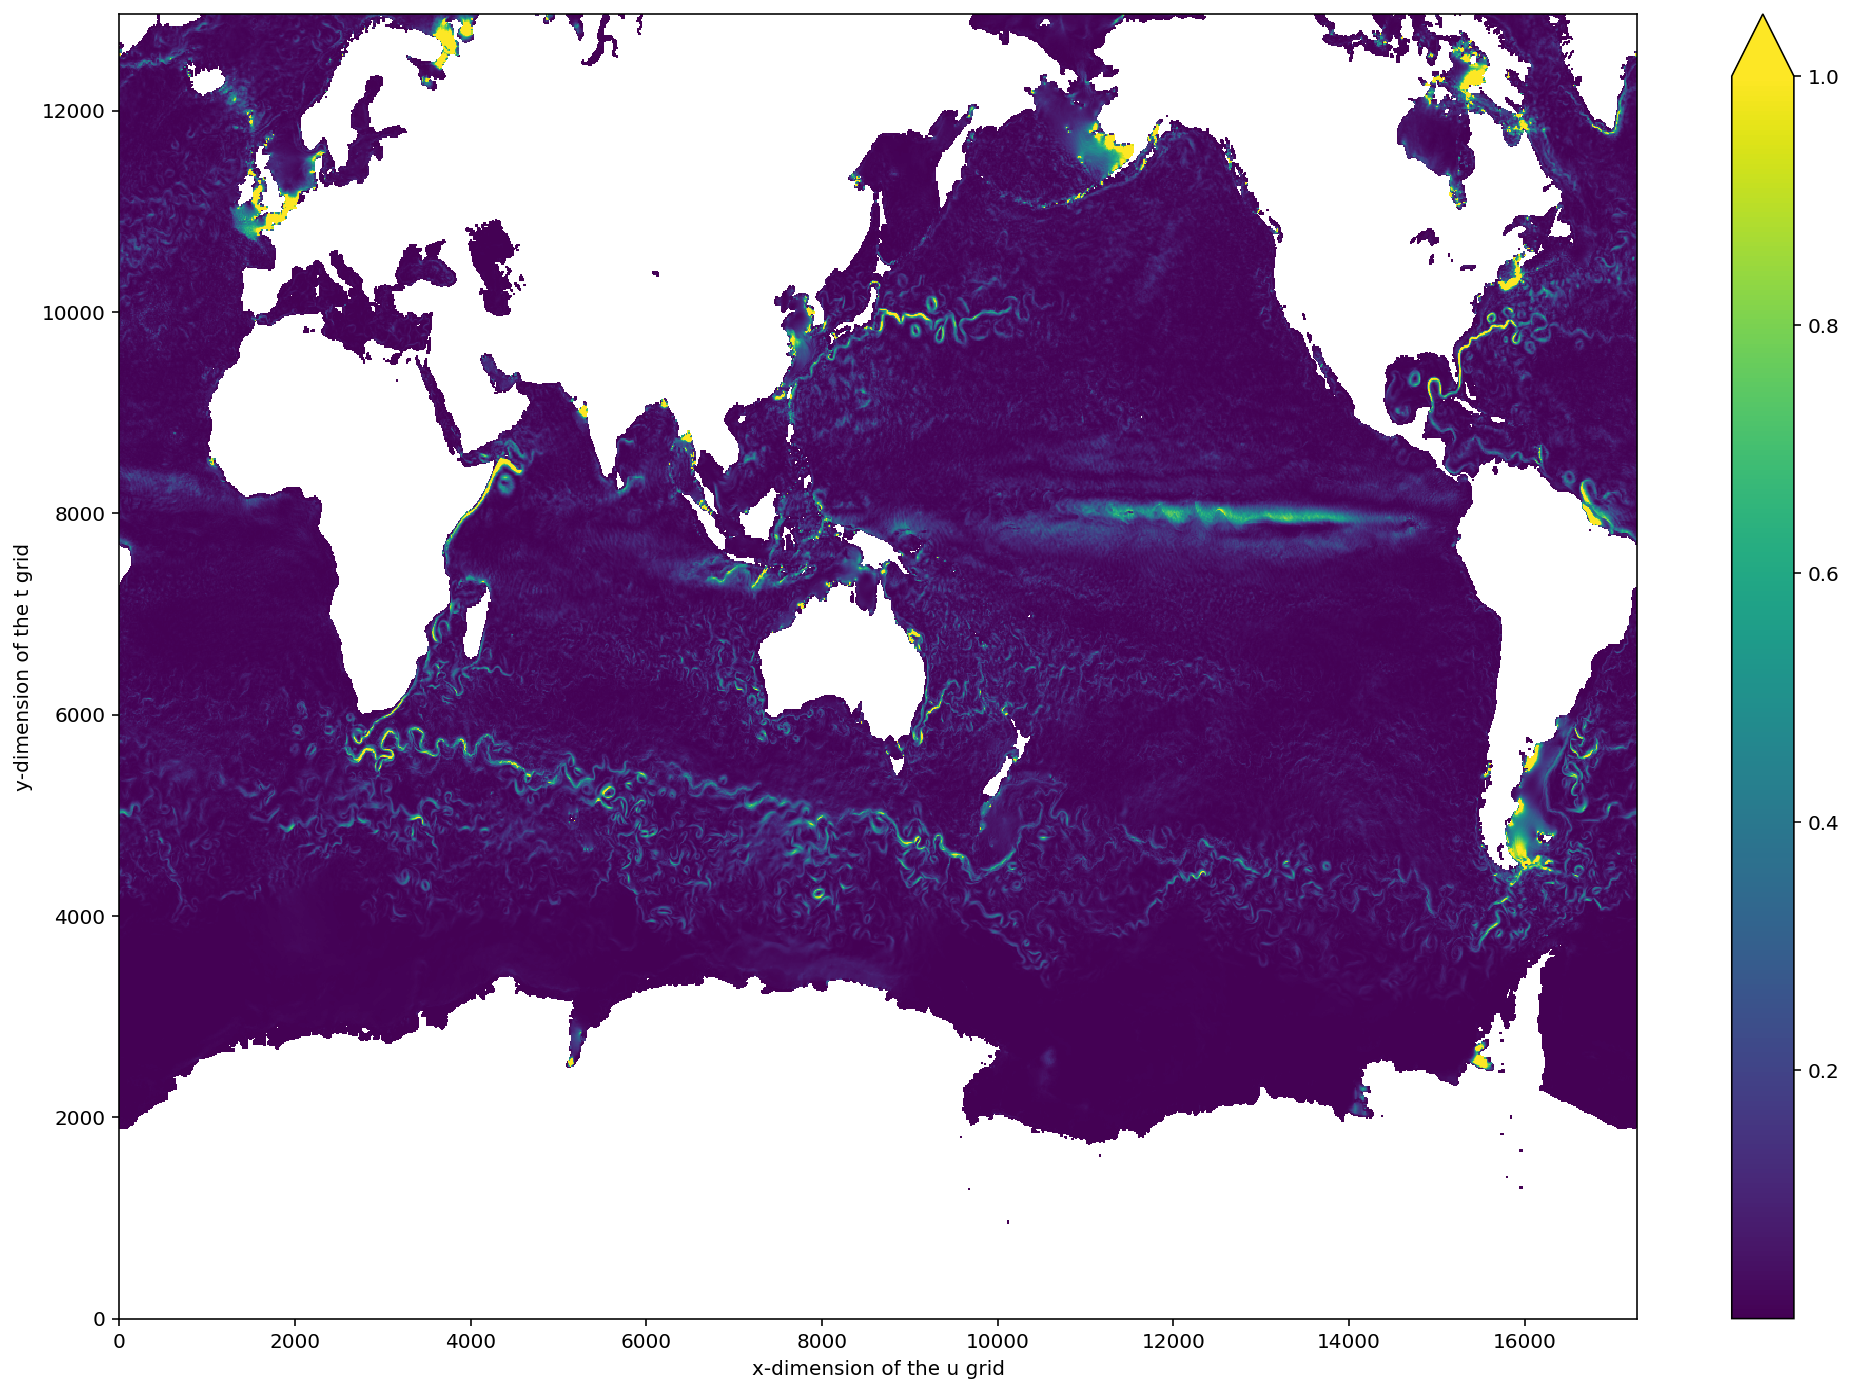

In [14]:
KE_coarse_mean.plot(figsize=(17, 12), vmax=1)